In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import zipfile
# !unzip /content/drive/MyDrive/Data/All_images.zip -d /content/drive/MyDrive/Data/Final

In [ ]:
# import os
# totalFiles = 0
# totalDir = 0
# for base, dirs, files in os.walk('/content/drive/MyDrive/Data/Final/All_images/'):
#     for directories in dirs:
#         totalDir += 1
#     for Files in files:
#         totalFiles += 1

# print(totalFiles)

In [ ]:
# !pip install timm
!pip install pytorch-lightning
!pip install albumentations

     |████████████████████████████████| 527 kB 4.1 MB/s 
     |████████████████████████████████| 133 kB 70.7 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 952 kB 58.8 MB/s 
     |████████████████████████████████| 829 kB 57.1 MB/s 
     |████████████████████████████████| 397 kB 79.5 MB/s 
     |████████████████████████████████| 1.1 MB 59.7 MB/s 
     |████████████████████████████████| 271 kB 85.5 MB/s 
     |████████████████████████████████| 144 kB 84.7 MB/s 
     |████████████████████████████████| 94 kB 4.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=b1ab633ab5707132857093b435206cf2b6ece475468b1e9a692685db30c70ebe
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

     |████████████████████████████████| 631 kB 4.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=b490d8ca6aa41bd11fec2126f60ea1f76e8d034c2eef268c56b4792a27ff6a9a
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
# !pip install pytorch_model_summary
import torch
import sys
from PIL import Image, ImageFile
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from collections import OrderedDict
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from typing import Optional # required for "Optional[type]"

# lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy

import albumentations as alb

print("PyTorch Lightning Version : {}".format(pl.__version__))

import warnings
warnings.filterwarnings("ignore", message=".*does not have many workers which may be a bottleneck.*")

import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

# import wandb
# wandb.init(reinit=True)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()

# personal_key_for_api = user_secrets.get_secret("wandb-key")

# !wandb login $personal_key_for_api

PyTorch Lightning Version : 1.5.10


In [ ]:
# NOTE: class is inherited from Dataset
class ImageLabelDataset(Dataset):
    def __init__(self, df_data, prediction, size=0, isTrain=True):
        super().__init__()
        self.df = df_data
        self.prediction = prediction
        self.isTrain = isTrain
        self.size = size

    def __len__(self):
        return len(self.df)

    @property
    def train_labels(self):
        # warnings.warn("train_labels has been renamed targets")
        return self.prediction

    def __getitem__(self, index):
        label = self.prediction[index]
        label_tensor = int(label)
        # label_tensor = torch.tensor(label, dtype=torch.float32)
        tensorimage = self.preprocess_image(self.df[index], self.size[index], label_tensor)
        return tensorimage, label_tensor
        # return {'image': tensorimage, 'labels': label_tensor}

    def preprocess_image(self, img_path, i_size, label):

        image_transform_train = alb.Compose([
            alb.Resize(p=1.0, width=2560, height=1920, interpolation=2),
            alb.CenterCrop(p=1.0, width=1100, height=1100),
            alb.Resize(p=1.0, width=224, height=224, interpolation=3),
            # alb.RandomResizedCrop(299, 299),
            # alb.Transpose(p=0.5),
            # alb.Rotate(p=0.5, limit=(-198, 242), interpolation=3),
            alb.HorizontalFlip(p=0.5),
            alb.VerticalFlip(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            alb.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
            alb.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
            alb.Cutout(p=0.5)
        ], p=1.0)

        image_transform_test = alb.Compose([
            alb.Resize(p=1.0, width=2560, height=1920, interpolation=2),
            alb.CenterCrop(p=1.0, width=1100, height=1100),
            alb.Resize(p=1.0, width=224, height=224, interpolation=3),
        ], p=1.0)

        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        folder = '/content/drive/MyDrive/Data/Final/All_images'
        if(self.isTrain):
            folder = '/content/drive/MyDrive/Data/Final/All_images'

        image = Image.open("{}/{}".format(folder, img_path))

        if(self.isTrain):
            transform_image = image_transform_train(image=np.array(image))['image']
            return preprocess(transform_image)
        else:
            transform_image = image_transform_test(image=np.array(image))['image']
            return preprocess(transform_image)

    def get_dummies(self, attribute_id):
        label_tensor = torch.zeros((1, 102))
        label_tensor[0, int(attribute_id)-1] = 1
        return label_tensor

In [ ]:
# Read CSV file into DataFrame df
BATCH_SIZE = 32

df_train = pd.read_csv('/content/drive/MyDrive/Data/Final_train.csv', encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/Data/Final_test.csv', encoding='utf-8')

df_compare = pd.read_csv('/content/drive/MyDrive/Data/OtherCSV/effnet-b7-unfreeze-v1_results.csv', encoding='utf-8')

df_infected = df_train[(df_train['label'] == 1) & (df_train['Size'] < 640)][:7500]
df_infected_1 = df_train[(df_train['label'] == 1)]
df_not_infected = df_train[(df_train['label'] == 0)]

print(df_infected.count())
print(df_infected_1.count())
print(df_not_infected.count())

df_infected = df_infected.append(df_infected_1, ignore_index=True)
df_append_final = df_infected.append(df_not_infected, ignore_index=True)

df_append_final = df_append_final.sample(frac = 1).reset_index()

df_infected_test = df_test[(df_test['label'] == 1)][:500]
df_not_infected_test = df_test[(df_test['label'] == 0)][:500]

df_append_final_test = df_infected_test.append(df_not_infected_test, ignore_index=True)
df_append_final_test = df_append_final_test.sample(frac = 1).reset_index()

print(df_train.count())

# df_append_final = df_train

label         0
image_name    0
Size          0
dtype: int64
label         4743
image_name    4743
Size          4743
dtype: int64
label         7886
image_name    7886
Size          7886
dtype: int64
label         12629
image_name    12629
Size          12629
dtype: int64


In [ ]:
# from os.path import exists
# for index, row in df_train.iterrows():
#   file_exists = exists('/content/drive/MyDrive/Data/Final/All_images/'+row['image_name'])
#   if(not file_exists):
#     print("image_name: ", row['image_name'])

In [ ]:
from torch.utils.data import DataLoader

train_image = df_train["image_name"].values
train_target = df_train["label"].values
train_size = df_train["Size"].values

test_image = df_test["image_name"].values
test_target = df_test["label"].values
test_size = df_test["Size"].values

val_image = df_append_final_test["image_name"].values
val_target = df_append_final_test["label"].values
val_size = df_append_final_test["Size"].values

train_dataset = ImageLabelDataset(df_data=train_image, prediction=train_target, size=train_size)
test_dataset = ImageLabelDataset(df_data=test_image, prediction=test_target, size=test_size, isTrain=False)
val_dataset = ImageLabelDataset(df_data=val_image, prediction=val_target, size=val_size, isTrain=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [ ]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=10,
   verbose=False,
   mode='min'
)

In [ ]:
MODEL_CKPT_PATH = '/content/drive/MyDrive/Data/'
MODEL_CKPT = 'Custom-softmax-{epoch:02d}-{val_loss:.2f}'

checkpoint_callback = ModelCheckpoint(
    dirpath=MODEL_CKPT_PATH,
    monitor='val_loss',
    filename=MODEL_CKPT ,
    save_top_k=3,
    mode='min')

In [ ]:
# timm.create_model('inception_resnet_v2', pretrained=False)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        # print("x=",x.view(batch_size, -1).size())
        return x.view(batch_size, -1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.normal_(0.0, y)
        m.bias.data.fill_(0)
        # torch.nn.init.normal_(m.weight, 1.0, 0.02)
        # torch.nn.init.zeros_(m.bias)

def create_model():
  model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=0, stride=1),
    # nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.MaxPool2d(2, padding=0, stride=2),
    nn.Conv2d(32, 32, 3, padding=0, stride=1),
    # nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    # nn.MaxPool2d(2, padding=0, stride=2),
    nn.AdaptiveAvgPool2d(54),
    Flatten(),
    nn.Linear(93312, 128),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
  )
  # model.apply(weights_init)
  model.load_state_dict(torch.load('/content/drive/MyDrive/Data/Saved/Custom_softmax.pt'))
  return model

In [ ]:
from torch.optim import Adam, SGD

class OtisClassifier(pl.LightningModule):
    def __init__(self, learning_rate=0.005):
        super().__init__()

        self.accuracy = Accuracy()
        self.model = create_model()
        self.lr = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, X_batch):
        return self.model(X_batch)

    def training_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        logits = self.model(X_batch)

        loss_val = self.loss_fn(logits.squeeze(), Y_batch)
        acc = binary_acc(logits, Y_batch)
        self.log('train_loss', loss_val, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss_val

    def training_epoch_end(self, outputs):
        # print("Train end ep")
        torch.save(self.model.state_dict(), "/content/drive/MyDrive/Data/Saved/Custom_softmax.pt")

    def validation_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        logits = self.model(X_batch)

        loss_val = self.loss_fn(logits.squeeze(), Y_batch)

        acc = binary_acc(logits, Y_batch)
        self.log('val_loss', loss_val, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss_val

    def test_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        logits = self.model(X_batch)

        #.unsqueeze(1)
        loss_val = self.loss_fn(logits.squeeze(), Y_batch)

        acc = binary_acc(logits, Y_batch)
        self.log('test_loss', loss_val, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        return loss_val

    def predict_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self.model(X_batch.float())
        return preds

    def configure_optimizers(self):
        print('Learning Rate', self.lr)
        # optimizer = Adam(self.model.parameters(), lr=self.lr)
        optimizer = SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        return optimizer

In [ ]:
# classifier = OtisClassifier(learning_rate=0.00001)
# classifier.unfreeze()
# classifier.freeze()
classifier = OtisClassifier.load_from_checkpoint(
    learning_rate=0.00001,
    checkpoint_path='/content/drive/MyDrive/Data/Saved/Custom-softmax-epoch=19-val_loss=0.68.ckpt'
)

# trainer = pl.Trainer(max_epochs=10, progress_bar_refresh_rate=20,
#                      log_every_n_steps=100,
#                      gpus=1,
#                      callbacks=[early_stop_callback, checkpoint_callback]
#                     ) #, deterministic=True)

trainer = pl.Trainer(max_epochs=25, gpus=1, callbacks=[early_stop_callback, checkpoint_callback], resume_from_checkpoint="/content/drive/MyDrive/Data/Saved/Custom-softmax-epoch=19-val_loss=0.68.ckpt")

trainer.fit(classifier, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:46: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1906: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  "`trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7."
Restoring states from the checkpoint path at /content/drive/MyDrive/Data/Saved/Custom-softmax-epoch=19-val_loss=0.68.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/p

Learning Rate 1e-05


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/MyDrive/Data exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.validate(classifier, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 56.88800048828125, 'val_loss': 0.6922315955162048}
--------------------------------------------------------------------------------


[{'val_acc': 56.88800048828125, 'val_loss': 0.6922315955162048}]

In [ ]:
trainer.test(classifier, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 65.1532211303711, 'test_loss': 0.6376740336418152}
--------------------------------------------------------------------------------


[{'test_acc': 65.1532211303711, 'test_loss': 0.6376740336418152}]

In [ ]:
preds = trainer.predict(classifier, test_loader)
# preds = torch.sigmoid(preds)

preds = torch.cat(preds)

preds = preds.argmax(axis=1)

preds[:100]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 395it [00:00, ?it/s]

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0])

In [ ]:
Y_test = []
for x,y in test_loader:
  Y_test.append(y)

Y_test = torch.cat(Y_test)
Y_test[:100]

tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1])

In [ ]:
# Y_pred_e = []
# df_final = pd.DataFrame(data=[])
# for index, row in df_compare.iterrows():
#   # Y_pred_e.append(torch.min(torch.tensor([preds[index], row["predicted"]])))
#   # Y_pred_e.append(torch.tensor([row["predicted"]]))
#   # Y_pred_e =
#   row_1 = dict()
#   row_1['image_name'] = row['image_name']
#   row_1['label'] = row['label']
#   row_1['predicted'] = preds[index].item()

#   df_final = df_final.append(row_1, ignore_index=True)

# df_final.to_csv('/content/drive/MyDrive/Data/inception_results.csv', index=False)
# # Y_pred_e = torch.stack(Y_pred_e)
# # Y_pred_e = torch.cat(Y_pred_e)
# # Y_pred_e[:100]

In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy : {:.3f}".format(accuracy_score(preds, Y_test)))

Test Accuracy : 0.652


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report : ")
print(classification_report(Y_test, preds))

Classification Report : 
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      7886
           1       0.61      0.20      0.30      4743

    accuracy                           0.65     12629
   macro avg       0.64      0.56      0.53     12629
weighted avg       0.64      0.65      0.59     12629



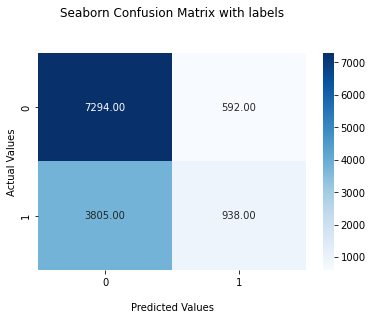

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(confusion_matrix(Y_test, preds), annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Display the visualization of the Confusion Matrix.
plt.show()